# MountainCar-v0 - Exercise

The Mountain Car problem is described as follows: a car is on a one-dimensional track, positioned between two mountains. The goal is to drive up the mountain on the right; however, the car’s engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.

## 1. State space

The car’s state, at any point in time, is given by a vector containing its horizontal position and velocity. The car commences each episode stationary, at the bottom of the valley between the hills (at position approximately -0.5), and the episode ends when either the car reaches the flag (position  0.6) or after 200 moves.

<img src="./resources/mountaincar.png" style="height: 250px"/>

We can load the game environment and render what it looks like.

In [27]:
import gym
env = gym.make('MountainCar-v0') # load the game environment
env.reset()

env.render() # visualize the environment

True

The environment opens in a different window. The environment works best if you shrink your browser a little bit and place the window with the car beside it. To close this window:

In [28]:
env.close()

First open the environment again. Now we can ask the car's state and print it.

In [3]:
print("State Space: {}\n".format(env.state))
print("Position: %f " % env.state[0])
print("Velocity: %f " % env.state[1])

State Space: [-0.50733262  0.        ]

Position: -0.507333 
Velocity: 0.000000 


As you can see, the state is a vector containing its horizontal position and velocity. Check in the figure if the car is indeed at the given horizontal position. The velocity should be zero. Right?

## 2. Reset the environment - Exercise

Try to reset the environment to a new random state, render it and print the state again. Do you see the car at a different location?

In [11]:
# reset the environment to a new, random state
env.reset()
env.render()
print("State Space: {}\n".format(env.state))


State Space: [-0.56372933  0.        ]



## 3. Action space

At each move, the car has three possible actions: push left (=0), push right (=2) or do nothing (=1), and a penalty of 1 unit is applied for each move taken (including doing nothing). This means that, unless the car can figure out a way to ascend the mountain in less than 200 moves, it will always achieve a total *reward* of -200 units.

The car performs an action by using the step-method:

```python
state, reward, done, info = env.step(action)
```

As you know the episode ends (done will be True) after 200 moves. We will try to push the car to the right at each move and render the environment at each step. We will also count the number of steps and print it. As you can see, the car's engine is not strong enough to drive up the mountain.

In [19]:
from IPython.display import clear_output

env.reset()
env.render()
step = 0
done = False
while not done:
    state, reward, done, info = env.step(2)
    env.render()
    step = step + 1
    clear_output(wait=True)
    print("Steps: %d" % step)

Steps: 200


## 4. Random actions - Exercise

Maybe you can try to reach the flag by performing a random action at each step? Any success?

In [20]:
from IPython.display import clear_output

env.reset()
env.render()
step = 0
done = False
while not done:
    state, reward, done, info = env.step(random.randint(0, 2))
    env.render()
    step = step + 1
    clear_output(wait=True)
    print("Steps: %d" % step)

Steps: 200


## 5. Solving the environment without Reinforcement Learning - Exercise

Can you figure out a strategy to reach the flag within 200 moves? Try to code your strategy! Count the number of steps. My best try was reaching the flag in 89 steps. Can you do better?

In [ ]:
# solving the problem without reinforcement learning



## 6. Solving the environment with Reinforcement Learning

So far, we have driven the car ourselves. This of course has nothing to do with Reinforcement Learning. The code below will use the Q-learning algorithm to let the agent use the environment's rewards to learn, over time, to take the best action to drive up the mountain. This code is just to demonstrate. This won't be an exam question.

For tracking purposes, the code returns a list containing the average total reward for each run of 100 episodes. It visualizes the movements of the Mountain Car only for the final 10 episodes using the `env.render()` method. The environment is only visualized for the final 10 episodes, rather than for all episodes, because visualizing the environment dramatically increases the code run time. So don't panic if the car doesn't move in the beginning.

In [21]:
import numpy as np
import matplotlib.pyplot as plt

env.reset()

# define Q-learning function
def QLearning(env, learning, discount, epsilon, min_eps, episodes):
    # Determine size of discretized state space
    num_states = (env.observation_space.high - env.observation_space.low)*\
                    np.array([10, 100])
    num_states = np.round(num_states, 0).astype(int) + 1
    
    # Initialize Q table
    Q = np.random.uniform(low = -1, high = 1, 
                          size = (num_states[0], num_states[1], 
                                  env.action_space.n))
    
    # Initialize variables to track rewards
    reward_list = []
    ave_reward_list = []
    
    # Calculate episodic reduction in epsilon
    reduction = (epsilon - min_eps)/episodes
    
    # Run Q learning algorithm
    for i in range(episodes):
        # Initialize parameters
        done = False
        tot_reward, reward = 0,0
        state = env.reset()
        
        # Discretize state
        state_adj = (state - env.observation_space.low)*np.array([10, 100])
        state_adj = np.round(state_adj, 0).astype(int)
    
        while done != True:   
            # Render environment for last five episodes
            if i >= (episodes - 20):
                env.render()
                
            # Determine next action - epsilon greedy strategy
            if np.random.random() < 1 - epsilon:
                action = np.argmax(Q[state_adj[0], state_adj[1]]) 
            else:
                action = np.random.randint(0, env.action_space.n)
                
            # Get next state and reward
            state2, reward, done, info = env.step(action) 
            
            # Discretize state2
            state2_adj = (state2 - env.observation_space.low)*np.array([10, 100])
            state2_adj = np.round(state2_adj, 0).astype(int)
            
            # Allow for terminal states
            if done and state2[0] >= 0.5:
                Q[state_adj[0], state_adj[1], action] = reward
                
            # Adjust Q value for current state
            else:
                delta = learning*(reward + 
                                 discount*np.max(Q[state2_adj[0], 
                                                   state2_adj[1]]) - 
                                 Q[state_adj[0], state_adj[1],action])
                Q[state_adj[0], state_adj[1],action] += delta
                                     
            # Update variables
            tot_reward += reward
            state_adj = state2_adj
        
        # Decay epsilon
        if epsilon > min_eps:
            epsilon -= reduction
        
        # Track rewards
        reward_list.append(tot_reward)
        
        if (i+1) % 100 == 0:
            ave_reward = np.mean(reward_list)
            ave_reward_list.append(ave_reward)
            reward_list = []
            
        if (i+1) % 100 == 0:    
            print('Episode {} Average Reward: {}'.format(i+1, ave_reward))
                
    return ave_reward_list

# run Q-learning algorithm
rewards = QLearning(env, 0.2, 0.9, 0.8, 0, 5000)

Episode 100 Average Reward: -200.0
Episode 200 Average Reward: -200.0
Episode 300 Average Reward: -200.0
Episode 400 Average Reward: -200.0
Episode 500 Average Reward: -200.0
Episode 600 Average Reward: -200.0
Episode 700 Average Reward: -200.0
Episode 800 Average Reward: -200.0
Episode 900 Average Reward: -200.0
Episode 1000 Average Reward: -200.0
Episode 1100 Average Reward: -200.0
Episode 1200 Average Reward: -200.0
Episode 1300 Average Reward: -200.0
Episode 1400 Average Reward: -200.0
Episode 1500 Average Reward: -200.0
Episode 1600 Average Reward: -200.0
Episode 1700 Average Reward: -200.0
Episode 1800 Average Reward: -200.0
Episode 1900 Average Reward: -200.0
Episode 2000 Average Reward: -200.0
Episode 2100 Average Reward: -200.0
Episode 2200 Average Reward: -200.0
Episode 2300 Average Reward: -200.0
Episode 2400 Average Reward: -200.0
Episode 2500 Average Reward: -199.99
Episode 2600 Average Reward: -200.0
Episode 2700 Average Reward: -200.0
Episode 2800 Average Reward: -200.0


In [26]:
env.close()

Plotting the average reward vs the episode number for the 5000 episodes, we can see that, initially, the average reward is fairly flat, with each run terminating once the maximum 200 movements is reached. This is the exploration phase of the algorithm. Only after 4000 episodes, the agent is making progress.

Text(0.5, 1.0, 'Average Reward vs Episodes')

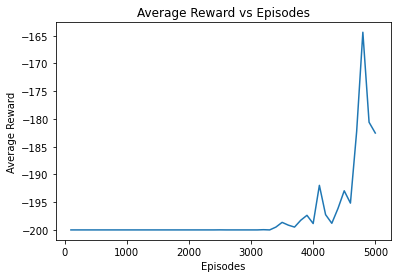

In [23]:
# plot rewards
plt.plot(100*(np.arange(len(rewards)) + 1), rewards)
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episodes')

Don't forget to close the environment.